<a href="https://colab.research.google.com/github/Marlianur09/Tugas_Praktikum_023_043/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/Semester 7/ML/Tugas Kelompok


/content/drive/MyDrive/Semester 7/ML/Tugas Kelompok


In [6]:
!ls 

ANN						       team_details.gsheet
aptos-eye-preprocessing-in-diabetic-retinopathy.ipynb  Untitled
dataset						       Untitled0.ipynb
model.h5					       Untitled1.ipynb
sprint_project.gsheet


In [7]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline

In [8]:
TRAINING_DIR = 'dataset/train_images'
TEST_DIR = 'dataset/test_images'
BATCH_SIZE = 64
#seed = 10
im_shape = (512,512)


#Datasets path
df_train_path = 'dataset/train.csv'
df_test_path = 'dataset/test.csv'

df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)

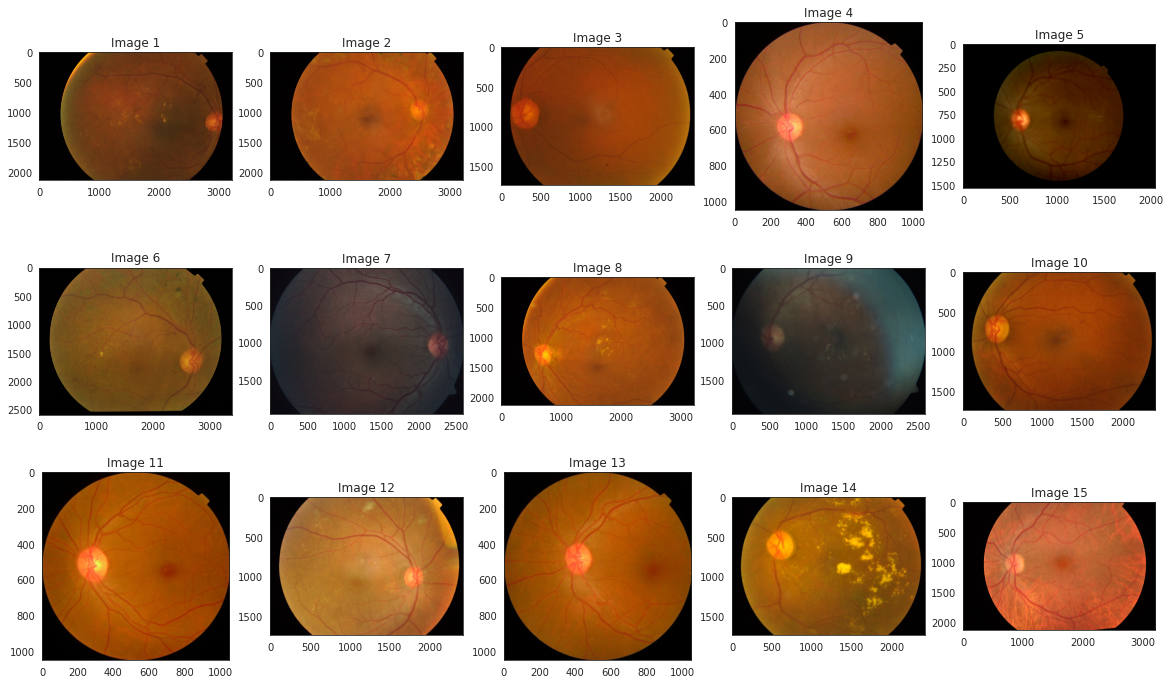

In [9]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in df_train['id_code'][:15]:
    img = cv2.imread("dataset/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [10]:
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [11]:
df_train['diagnosis'] = df_train['diagnosis'].astype(str)
df_train['id_code'] = df_train['id_code'].astype(str)+'.png'

df_test['id_code'] = df_test['id_code'].astype(str)+'.png'

In [12]:
# With augmentation
data_generator = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
)
val_data_generator = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

In [13]:
train_generator = data_generator.flow_from_dataframe(directory=TRAINING_DIR, target_size=im_shape, shuffle=True,
                                                     class_mode='categorical', batch_size=BATCH_SIZE,
                                                     dataframe=df_train, x_col='id_code', y_col='diagnosis'
                                                    )

validation_generator = val_data_generator.flow_from_dataframe(directory=TRAINING_DIR, target_size=im_shape, shuffle=False,
                                                              class_mode='categorical', batch_size=BATCH_SIZE, 
                                                              dataframe=df_train, x_col='id_code', y_col='diagnosis'
                                                             )

test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_dataframe(directory=TEST_DIR, target_size=im_shape, shuffle=False,
                                                    class_mode=None, batch_size=BATCH_SIZE,
                                                    dataframe=df_test, x_col='id_code'#, y_col='diagnosis'
                                                   )

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 3662 validated image filenames belonging to 5 classes.
Found 3662 validated image filenames belonging to 5 classes.
Found 1927 validated image filenames.
Classes: ['0', '1', '2', '3', '4']


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  .format(n_invalid, x_col)


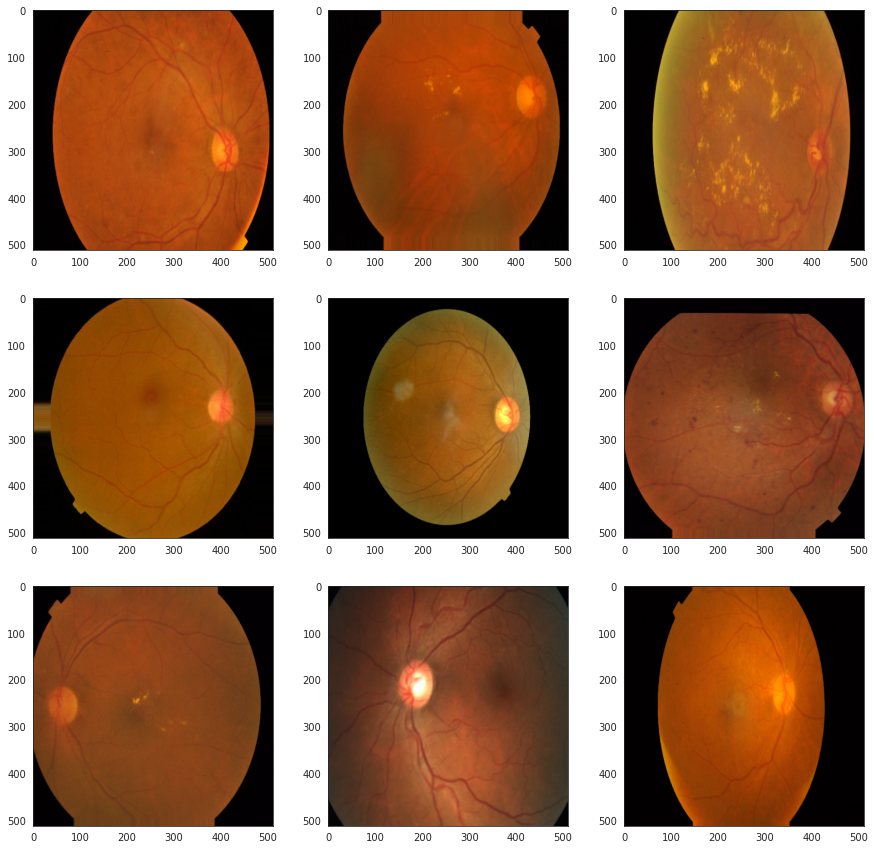

In [14]:
# Visualizando alguns exemplos do dataset por meio do Generator criado
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 20)      560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 15)      2715      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 15)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 10)      1360      
_________________________________________________________________
flatten_1 (Flatten)          (None, 153760)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                7

KeyboardInterrupt: ignored

In [22]:
from tensorflow.keras import layers
from tensorflow.keras import Model

img_input = layers.Input((im_shape[0],im_shape[1],3)) # layer input
x = layers.Flatten()(img_input) # ubah dari matriks 100x100x3 menjadi vektor
x = layers.Dense(64, activation='relu')(x) # hidden layer 1 dengan 128 neuron
x = layers.Dense(32, activation='relu')(x) # hidden layer 1 dengan 128 neuron
output = layers.Dense(num_classes, activation='softmax')(x) # output layer dengan 1 neuron (binary)

# Definisikan modelnya
model2 = Model(img_input, output)

In [23]:
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [24]:
epochs = 6
#Callback to save the best model
callbacks_list2 = [
    keras.callbacks.ModelCheckpoint(
        filepath='model2.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,verbose=1)
]

#Training
history2 = model2.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list2,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/6
57/57 [==============================] - 1307s 23s/step - loss: 29.8316 - accuracy: 0.4669 - val_loss: 19.3437 - val_accuracy: 0.4550

Epoch 00001: val_loss improved from inf to 19.34373, saving model to model2.h5
Epoch 2/6
57/57 [==============================] - 1293s 23s/step - loss: 9.9210 - accuracy: 0.5450 - val_loss: 6.1989 - val_accuracy: 0.5943

Epoch 00002: val_loss improved from 19.34373 to 6.19893, saving model to model2.h5
Epoch 3/6
57/57 [==============================] - 1291s 23s/step - loss: 11.1924 - accuracy: 0.5267 - val_loss: 5.6033 - val_accuracy: 0.6294

Epoch 00003: val_loss improved from 6.19893 to 5.60329, saving model to model2.h5
Epoch 4/6
57/57 [==============================] - 1293s 23s/step - loss: 5.9928 - accuracy: 0.5539 - val_loss: 7.8666 - val_accuracy: 0.4411

Epoch 00004: val_loss did not improve from 5.60329
Epoch 5/6
57/57 [==============================] - 1288s 23s/step - loss: 7.9919 - accuracy: 0.5575 - val_loss: 6.8070 - val_accur

In [30]:
score = model2.evaluate(train_generator)

print('Loss: {:.2f}'.format(score[0]))
print('Accuracy: {:.2f}'.format(score[1]))


13/58 [=====>........................] - ETA: 9:10 - loss: 6.7439 - accuracy: 0.5373

KeyboardInterrupt: ignored

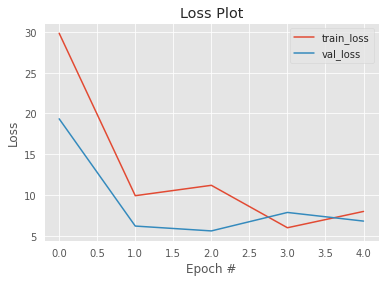

In [29]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 5), history2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5), history2.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

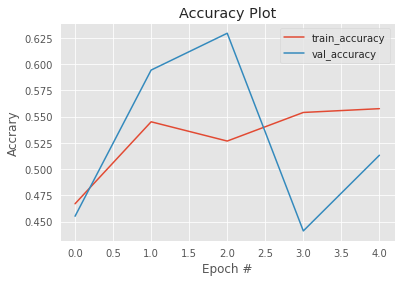

In [32]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 5), history2.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 5), history2.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accrary")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

pred = model2.predict(validation_generator)
labels = (pred > 0.5).astype(np.int)

print(classification_report(validation_generator, labels))